## <center>Fama Macbeth Regression</center>

### <center>Get, Format and Check the Data</center>

In [6]:
from helpers import *

returns_portfolio = pd.read_excel('data/Refinitv_MonthlyReturns.xlsx', index_col=0, parse_dates=True)
factor_data = pd.read_excel('data_copulas/Factor_UpsideRatio.xlsx', index_col=0, parse_dates=True)
no_lag_factor_data = factor_data.loc['2006-07-01':'2016-06-01']

fama_french_3_factor = pd.read_excel('data/FF_RF.xlsx', index_col=0, parse_dates=True)
fama_french_3_factor = fama_french_3_factor / 100

mkt_rf = fama_french_3_factor[['Mkt-RF']]
risk_free_rate = fama_french_3_factor[['RF']]

returns_portfolio.index = returns_portfolio.index.to_period('M')
risk_free_rate.index = risk_free_rate.index.to_period('M')
mkt_rf.index = mkt_rf.index.to_period('M')
fama_french_3_factor.index = fama_french_3_factor.index.to_period('M')
factor_data.index = factor_data.index.to_period('M')

print("Before Drop NA's")
print_checks_01(returns_portfolio, risk_free_rate, factor_data)

# Drop NA's
returns_portfolio = returns_portfolio.dropna(axis=1, how='any')
no_lag_factor_data = factor_data.dropna(axis=1, how='any')

# Drop columns which are not in both
print('Columns not in both', set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)))
returns_portfolio = returns_portfolio.drop(columns=set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)))
factor_data = factor_data.drop(columns=set(factor_data.columns).difference(set(returns_portfolio.columns)))
print('Columns not in both', set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)), '\n')

print("After Drop NA's")
print_checks_01(returns_portfolio, risk_free_rate, no_lag_factor_data)

# Check if returns and Rf have same decimal format side by side
print(returns_portfolio.iloc[:, :2].head(), '\n')
print(fama_french_3_factor.head())

Before Drop NA's
RiskF First Date: 2006-07 Last Date: 2016-06 Shape: (120, 100)
Portf First Date: 2006-07 Last Date: 2016-06 Shape: (120, 1)
Factor First Date: 2001-07 Last Date: 2016-12 Shape: (186, 100) 

Columns not in both {'AEP', 'SLB', 'AES', 'AMGN'}
Columns not in both set() 

After Drop NA's
RiskF First Date: 2006-07 Last Date: 2016-06 Shape: (120, 61)
Portf First Date: 2006-07 Last Date: 2016-06 Shape: (120, 1)
Factor First Date: 2001-07 Last Date: 2016-12 Shape: (186, 62) 

              AXP        VZ
Date                       
2006-07 -0.019000  0.023500
2006-08  0.009174  0.040156
2006-09  0.067374  0.055420
2006-10  0.033595  0.008633
2006-11  0.015748 -0.019942 

         Mkt-RF     SMB     HML      RF
Date                                   
2006-07 -0.0078 -0.0398  0.0260  0.0040
2006-08  0.0203  0.0103 -0.0206  0.0042
2006-09  0.0184 -0.0136  0.0008  0.0041
2006-10  0.0323  0.0175 -0.0031  0.0041
2006-11  0.0171  0.0070  0.0014  0.0042


### <center>Run First Time Series Regression to get Betas</center>

$$
r_t^i - r_{ft} = \gamma_i + \beta_i (r_t^m - r_{f})_{t} + \epsilon_{it}
$$

In [7]:
excess_returns = returns_portfolio.subtract(risk_free_rate['RF'], axis=0)

betas = pd.DataFrame(index=excess_returns.columns, columns=['Beta']) #! Implement Rolling betas
for stock in excess_returns.columns:
    model = sm.OLS(excess_returns[stock], sm.add_constant(mkt_rf)).fit()
    betas.loc[stock, 'Beta'] = model.params['Mkt-RF']

print(betas.head())

         Beta
AXP  1.643583
VZ   0.495679
BA   1.174203
BMY  0.581673
KO    0.53256


### <center>Run Second Cross Sectional Regression obtain Gammas</center>

$$
r_i^t - r_{ft} = \lambda_1^t + \lambda_2^t \beta_i + \lambda_3^t \text{(Upside Ratio)}_i^t + \alpha_{it}
$$

In [8]:
gammas = pd.DataFrame(index=excess_returns.index, columns=['Gamma 0', 'Gamma 1', 'Gamma 2'])

for month in excess_returns.index:
    Y = excess_returns.loc[month].dropna()
    X1 = betas.loc[Y.index].astype(float)
    factor_data_x2 = factor_data.loc[[month]].astype(float)
    X2 = factor_data_x2.T
    X2.columns = ['Factor']
    
    Y = Y.loc[X1.index]
    X2 = X2.loc[X1.index]

    if not X1.empty and not X2.empty:
        X = sm.add_constant(pd.concat([X1, X2], axis=1))
        
        if not X.replace([np.inf, -np.inf], np.nan).dropna().empty:
            model = sm.OLS(Y, X).fit()
            
            gammas.loc[month, 'Gamma 0'] = model.params.get('const', np.nan)
            gammas.loc[month, 'Gamma 1'] = model.params.get('Beta', np.nan)
            gammas.loc[month, 'Gamma 2'] = model.params.get('Factor', np.nan)

print(gammas.head())

          Gamma 0   Gamma 1   Gamma 2
Date                                 
2006-07  0.065325 -0.038872 -0.026152
2006-08 -0.027975  0.003135  0.047867
2006-09  0.013709   0.00009  0.014781
2006-10   0.02717  0.007429  0.000189
2006-11 -0.018854  0.015751  0.017054


### <center>Plot Gammas for Beta and Upside Ratio</center>

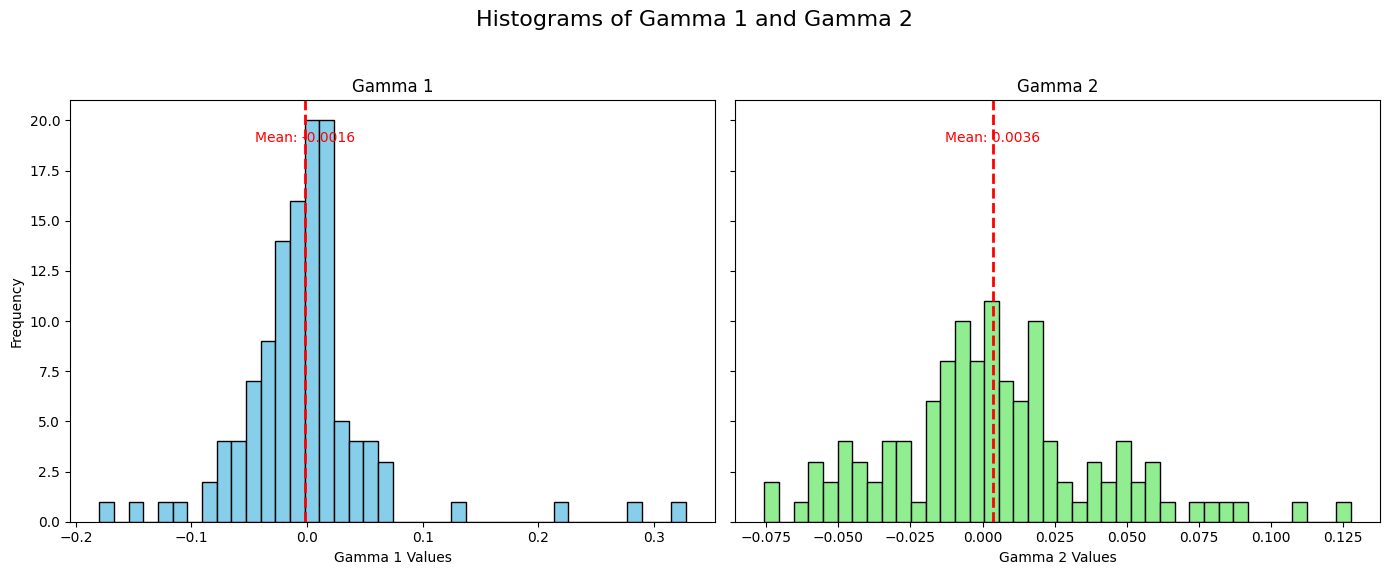

In [9]:
plot_gamma_histograms(gammas)

### <center>Obtain Final Gammas with T-Statistic and P-Test</center>

In [10]:
# Clean
gammas['Gamma 1'] = pd.to_numeric(gammas['Gamma 1'], errors='coerce')
gammas['Gamma 2'] = pd.to_numeric(gammas['Gamma 2'], errors='coerce')

# Calculate means
mean_gamma1 = gammas['Gamma 1'].mean()
mean_gamma2 = gammas['Gamma 2'].mean()

# Perform t-tests
t_test_gamma1 = stats.ttest_1samp(gammas['Gamma 1'], 0)
t_test_gamma2 = stats.ttest_1samp(gammas['Gamma 2'], 0)

summary_results_data = {
    "Parameter": ["Gamma 1", "Gamma 2"],
    "Mean": [mean_gamma1, mean_gamma2],
    "T-Statistic": [t_test_gamma1.statistic, t_test_gamma2.statistic],
    "P-Value": [t_test_gamma1.pvalue, t_test_gamma2.pvalue]
}

summary_results_df = pd.DataFrame(summary_results_data)

styled_df = summary_results_df.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [('font-size', '12pt'), ('background-color', 'lightgrey'), ('color', 'black'), ('border-color', 'white')]
    }]
).set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'border': '1px solid black'
}).applymap(
    lambda x: 'font-weight: bold' if isinstance(x, float) and x < 0.05 else '',
    subset=['P-Value']
).format({
    'Mean': "{:.6f}",
    'T-Statistic': "{:.4f}",
    'P-Value': "{:.4f}"
})

display(styled_df)

/var/folders/2_/86b4jc217ysdc4kf9wj_zbgh0000gn/T/ipykernel_53503/1779570993.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(


,Parameter,Mean,T-Statistic,P-Value
0,Gamma 1,-0.001619,-0.2868,0.7748
1,Gamma 2,0.003645,1.0828,0.2811


### <center>Gamma Values and Distribution Interpretation</center>

**Gamma 1 (Coefficient for Beta)**
- **Mean:** -0.001619
- **T-Statistic:** -0.2868
- **P-Value:** 0.7748

**Interpretation:**
Gamma 1s slightly negative mean and its distribution centered around zero (as seen in histograms) indicate a negligible influence of market beta on excess returns. The insignificance, confirmed by a high P-value, suggests that the value is not statistically significnty different to zero, hence there is no consistent impact of market beta across the analyzed months.

**Gamma 2 (Coefficient of Upside Ratio Factor)**
- **Mean:** 0.003645
- **T-Statistic:** 1.0828
- **P-Value:** 0.2811

**Interpretation:**
Gamma 2 shows a positive mean, suggesting a potential positive impact of the investment strategy on excess returns. However, the effect is not statistically significant across the sample period, as indicated by the P-value. The distribution, showing more months with positive than negative impacts, supports this, but lacks consistent statistical backing.

### <center>Conclusion</center>
Both Gamma 1 and Gamma 2 distributions reflect considerable variability with most values clustering near zero, indicating no strong, consistent influence from either market beta or the investment strategy factor. While individual months might display significant relationships, these do not aggregate into a reliable pattern over the sample period, underscoring the complex dynamics at play in predicting excess returns through these variables.